# MCT4052 Workshop 7e: Regressive ANN for Raw Audio Generation

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This notebook demonstrate the principle of autoregressive neural network to generate (autoregressively) a raw audio signal (i.e. audio samples). As for the previous notebook, a deep learning frameworks are better suited to build a such kind of neural network, as they allow to customize in detail the internal architecture of the ANN (type of layers, interconnection, etc.). With scikit-learn we are limited to use a feed-forward fully connected ANN (also called "dense" in other frameworks). In this case we implement the autoregression manually, creating an sample pipeline (delay-line like) line storing previously generated samples.

In the example, we generate sinuosid signal, and we use the oldest 500 samples to predict the next one (the ANN is a regressor with 500 inputs an one output). After the ANN is trained, the inference process starts with a sample pipeline line full of noise, that we gradually fill up with ANN generated audio samples.

We also experiment manipulating the contents of the sample pipeline line to generate slightly different sonic outputs.

In [1]:
import numpy as np
import pandas as pd
import librosa
import sklearn
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib nbagg
import IPython.display as Ipd
import os

### 1. Generating a long reference signal that the ANN will learn

<IPython.core.display.Javascript object>


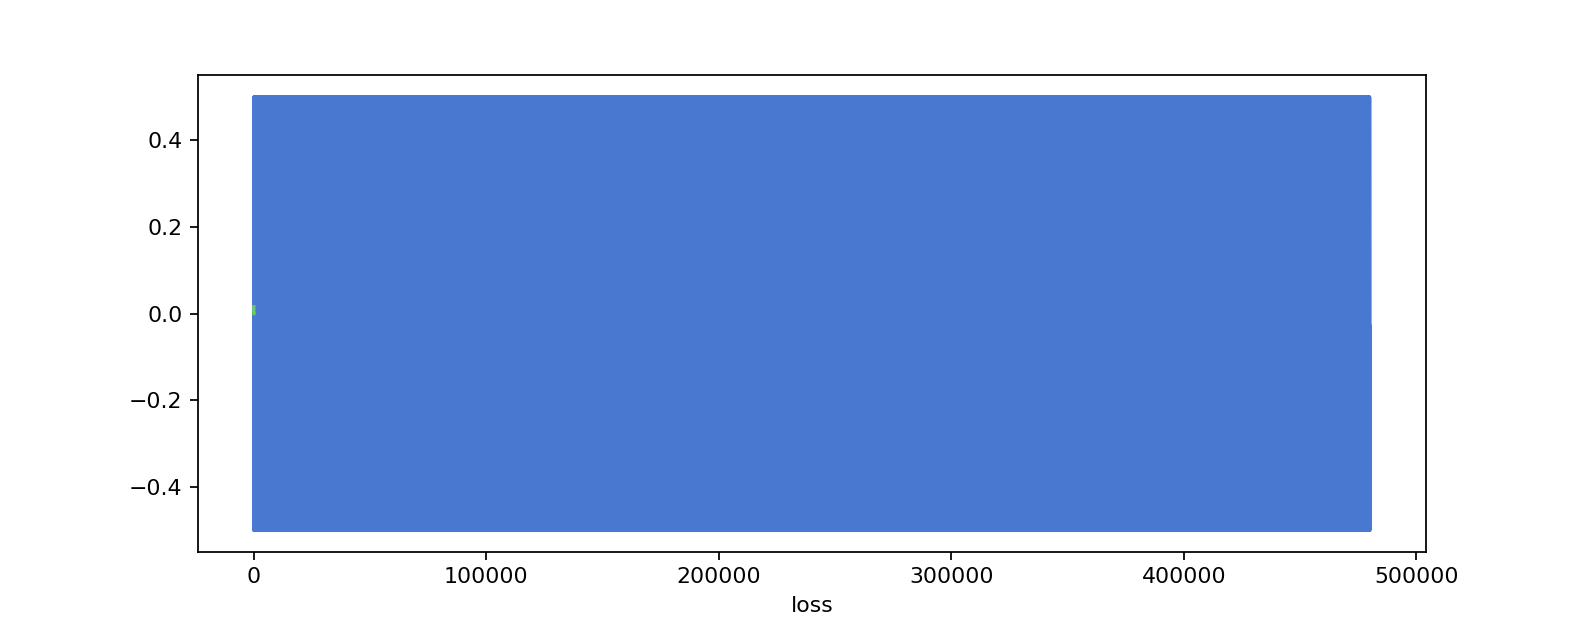

In [2]:
#generating periodic sinusoidal signal


sr = 48000

#frequency
f1 = 440

#amplitude
A = 0.5

t=np.arange(0,10,1/sr)

s = A*np.sin(2*np.pi*f1*t)

plt.figure(figsize=(10, 4))
plt.plot(s)
plt.show()

### 2. Building dataset taking input-sequences and output-target from the reference signal at random points

In [3]:
#setting size of the recursion and size of dataset
recursion_smp = 500
dataset_size = 10000

#creating empty arrays for input and output
input_data=np.zeros((dataset_size,recursion_smp))
output_data=np.zeros(dataset_size)

i = 0

#taking slizes of recursion_smp samples at random points plus the following sample as target output
while (i < dataset_size):
    index = int(s.size*np.random.random_sample(1))
    if s.size - index < (recursion_smp+1):
        continue
    input_data[i,:] = s[index:index+recursion_smp]
    output_data[i] = s[index+recursion_smp]
    #print(output_data[i],'VS',input_data[i,recursion_smp-1])
    i += 1


### 3. Training the regressor

In [4]:
from sklearn.neural_network import MLPRegressor

##Creating an instance of a MLP regressor
#and setting it some option (max mum epoch, verbose on, activation of neurons)
mlp = MLPRegressor(hidden_layer_sizes=(200,100,50), max_iter=20000, activation='logistic', tol=1e-5, verbose=True)

#train the model
mlp.fit(input_data, output_data)

Iteration 1, loss = 0.01622265
Iteration 2, loss = 0.00048238
Iteration 3, loss = 0.00006062
Iteration 4, loss = 0.00005417
Iteration 5, loss = 0.00005258
Iteration 6, loss = 0.00005172
Iteration 7, loss = 0.00005096
Iteration 8, loss = 0.00005021
Iteration 9, loss = 0.00004943
Iteration 10, loss = 0.00004864
Iteration 11, loss = 0.00004784
Iteration 12, loss = 0.00004703
Iteration 13, loss = 0.00004621
Iteration 14, loss = 0.00004539
Training loss did not improve more than tol=0.000010 for 10 consecutive epochs. Stopping.


MLPRegressor(activation='logistic', hidden_layer_sizes=(200, 100, 50),
             max_iter=20000, tol=1e-05, verbose=True)

In [5]:
#plotting the loss curve over training iteration 
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.xlabel('loss')
plt.show()

#applying the the model on the test data (features)
prediction = mlp.predict(input_data)

#coefficient of determination (r2 score): 1 is perfect prediction (it can get arbitrary negative)
print('Coefficient of determination (r2 score): %.4f'% sklearn.metrics.r2_score(output_data, prediction))

Coefficient of determination (r2 score): 1.0000


### 4. Using the regressor recursively feeding back the output in the input pipeline one sample at a time

In [6]:
#size of the generated signal in samples
out_sig_size = 100000

#starting with a sample pipeline full of noise
inout_pipeline = np.random.random_sample(recursion_smp)

#empty array for the output signal
sig_out = np.zeros(out_sig_size)

#loop generating signal offline
i = 0
while (i < out_sig_size):
    temp = mlp.predict(inout_pipeline.reshape(1,-1))
    sig_out[i] = temp
    inout_pipeline = np.append(inout_pipeline,temp)#latest output one at the end
    inout_pipeline = np.delete(inout_pipeline,0)#removing the oldest from the front
    i += 1



<IPython.core.display.Javascript object>


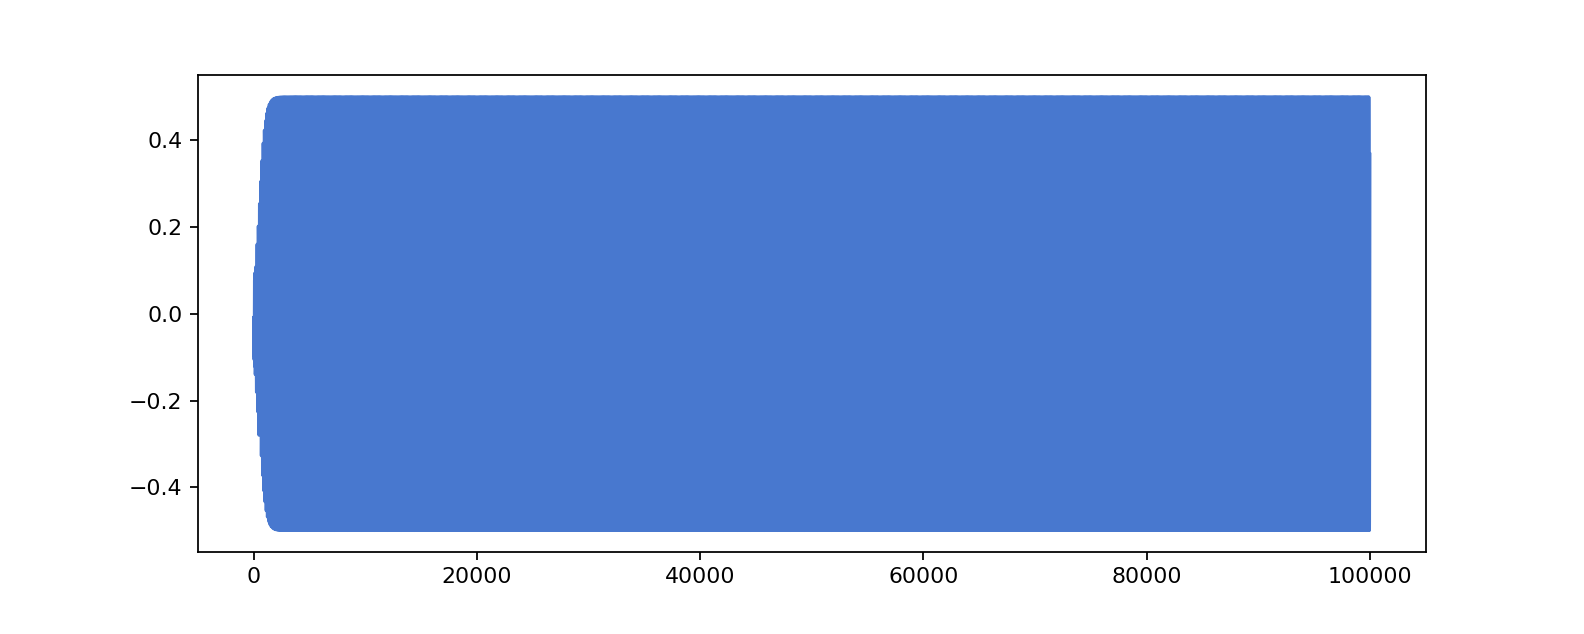

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(sig_out)
plt.show()

Ipd.display(Ipd.Audio(sig_out.flatten(), rate=sr))

### 5. Experimenting with manual alteration of the sample pipeline

In [8]:
#size of the generated signal in samples
out_sig_size = 100000

#starting with a sample pipeline full of noise
inout_pipeline = np.random.random_sample(recursion_smp)

#empty array for the output signal
sig_out = np.zeros(out_sig_size)

#loop generating signal offline
i = 0
while (i < out_sig_size):
    temp = mlp.predict(inout_pipeline.reshape(1,-1))
    sig_out[i] = temp
    if np.random.random_sample(1) > 0.85: #once in a we alter randomly the signal that coes back in the pipeline
        temp = (np.random.random_sample(1)*2) -1
    inout_pipeline = np.append(inout_pipeline,temp)#latest output one at the end
    inout_pipeline = np.delete(inout_pipeline,0)#removing the oldest from the front
    i += 1

<IPython.core.display.Javascript object>


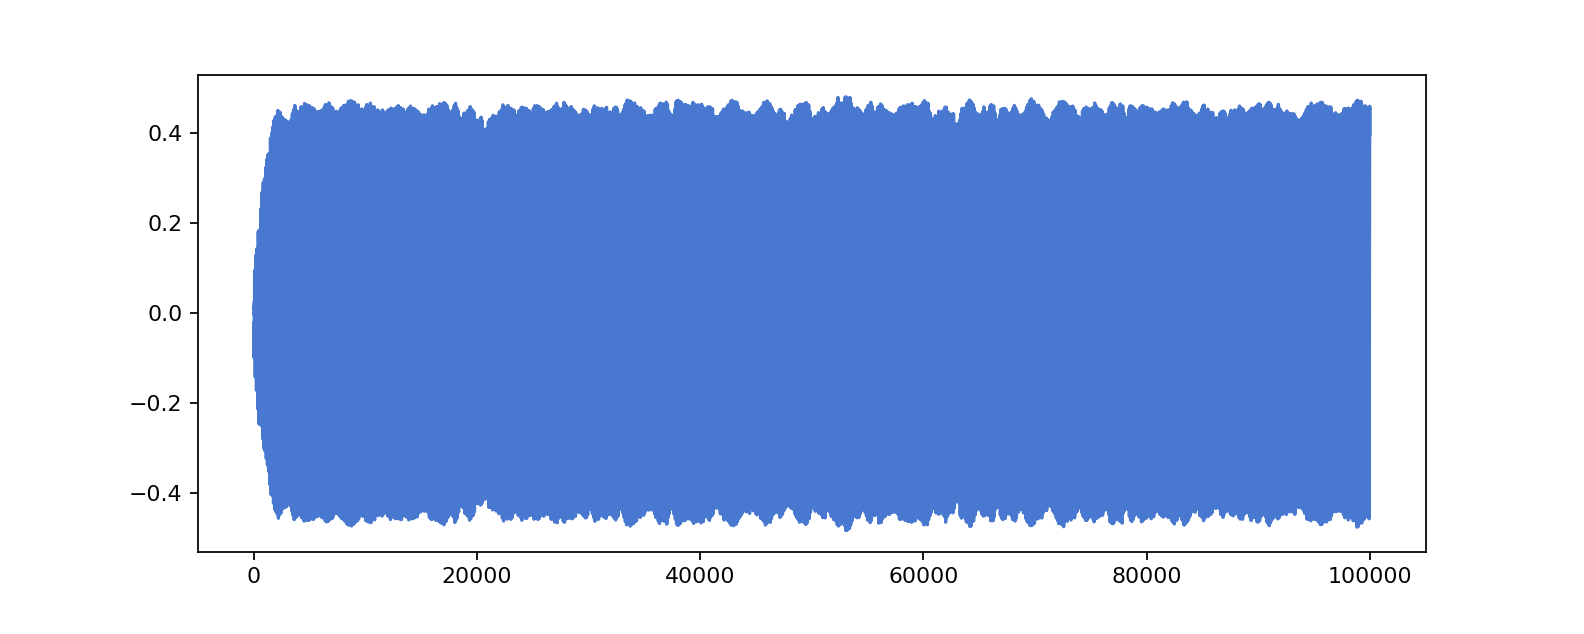

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(sig_out)
plt.show()

Ipd.display(Ipd.Audio(sig_out.flatten(), rate=sr))